# Лабораторная работа №4.
## Сети с радиальными базисными элементами.
### Выполнила: Михеева Кристина Олеговна
#### Группа М8О-407Б-20
##### Вариант: 15

## Цель работы

Целью работы является исследование свойств некоторых видов сетей с радиальными базисными элементами, алгоритмов обучения, а также применение сетей в задачах классификации и
аппроксимации функции.


## Ход работы

## Задание 1
Использовать многослойную нейронную сеть для классификации точек в случае, когда
классы не являются линейно разделимыми.


Для начала извлечем некоторые библиотеки, которые помогут нам в выполнении данной работы. Для построение графика нам понадобится библиотека - *matplotlib*, для выполнение операций с массивами мы подключим - *numpy*, а также библиотеку для обучния нейронных сетей - *torch*

In [2]:
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error

from itertools import product


Запишем параметры в словари трех алгебраических линий. У меня варианте предствлены два эллипса и одна парабола.

In [45]:
ellipse1 = dict(
    a = 0.4,  #большая полуось эллипса
    b = 0.15, #большая полуось эллипса
    alpha = np.pi/6, #угол пороврота
    x0 = 0, #координата параллельного переноса по х0
    y0 = 0  #координата параллельного переноса по у0
)

ellipse2 = dict(
    a = 0.7,
    b = 0.5,
    alpha = np.pi/3,
    x0 = 0,
    y0 = 0
)

parabola_params = dict(
    p = 1,  #параметр параболы
    alpha = np.pi/2,
    x0 = 0,
    y0 = -0.8
)

t_el = np.linspace(0, 2*np.pi, int(2*np.pi/0.025)) #параметр генерации точек для параметрического уравнения линии в канонической с истеме координат для эллипсов
t_pr = np.linspace(-1, 1, int(2/0.025)) #параметр генерации точек для параметрического уравнения линии в канонической с истеме координат для параболы

Генерируем точки алгебраических линий с помощью параметричечких уравнений в канонической системе координат.

In [46]:
# Уравнение эллипса в параметрическом виде.
def ellipse(a, b, alpha,  x0, y0):
    t = np.linspace(0, 2*np.pi, int(2*np.pi/0.025))
    x = a * np.cos(t) * np.cos(alpha) - b * np.sin(t) * np.sin(alpha) + x0
    y = a * np.cos(t) * np.sin(alpha) + b * np.sin(t) * np.cos(alpha) + y0
    return x, y

# Уравнение параболы в параметрическом виде.
def parabola(p, alpha, x0, y0):
  t = np.linspace(-1, 1, int(2/0.025))
  x = (t**2/(2*p)) * np.cos(alpha) - t*np.sin(alpha) + x0
  y = (t**2/(2*p)) * np.sin(alpha) + t*np.cos(alpha) + y0
  return x, y


Выведим как изначально построились точки с выборкой 60, 100, 120 для трех классов соотвесвенно.

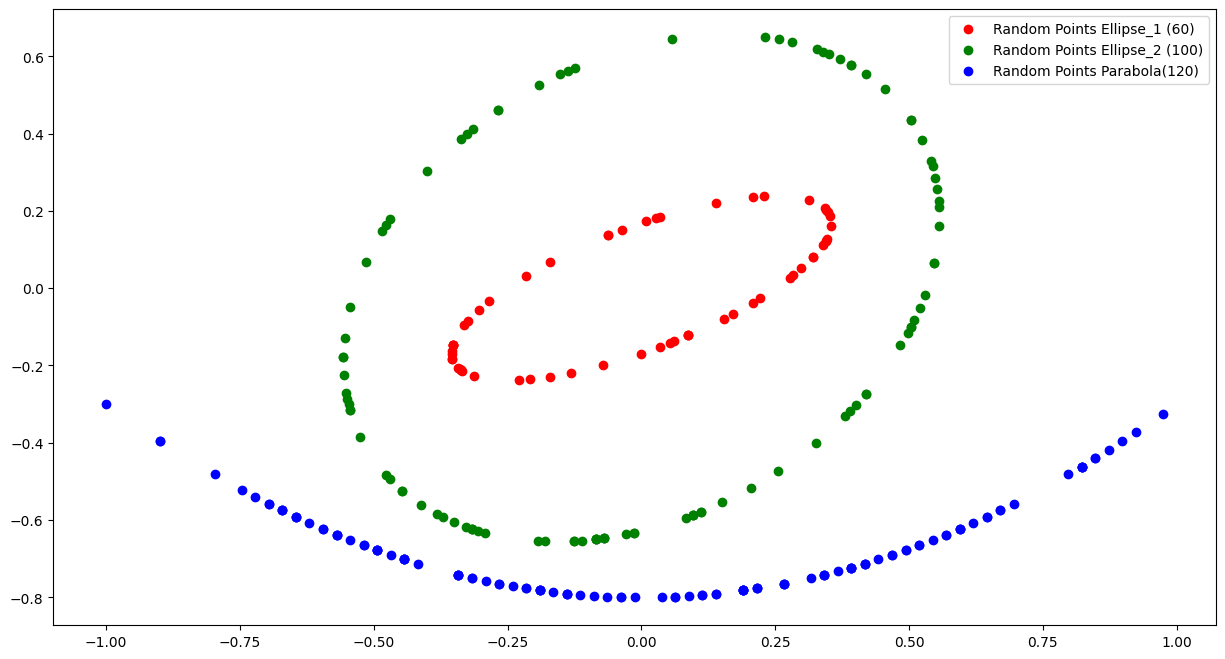

In [47]:
figure = plt.figure(figsize=(15, 8))

# Генерация 60 случайных точек на графике ellipse1
el1_x, el1_y = ellipse(ellipse1["a"], ellipse1["b"], ellipse1["alpha"], ellipse1["x0"], ellipse1["y0"])
random_indices_el1 = np.random.choice(len(t_el), 60)
random_x_el1, random_y_el1  = el1_x[random_indices_el1], el1_y[random_indices_el1]
plt.scatter(random_x_el1, random_y_el1, c='r', label='Random Points Ellipse_1 (60)', marker='o')

# Генерация 100 случайных точек на графике ellipse2
el2_x, el2_y = ellipse(ellipse2["a"], ellipse2["b"], ellipse2["alpha"], ellipse2["x0"], ellipse2["y0"])
random_indices_el2 = np.random.choice(len(t_el), 100)
random_x_el2,random_y_el2 = el2_x[random_indices_el2],el2_y[random_indices_el2]
plt.scatter(random_x_el2, random_y_el2, c='g', label='Random Points Ellipse_2 (100)', marker='o')

#Генерация 120 случайных точек на графике parabola
pr_x, pr_y = parabola(parabola_params['p'], parabola_params['alpha'], parabola_params['x0'], parabola_params['y0'])
random_indices_pr = np.random.choice(len(t_pr), 120)
random_x_pr, random_y_pr = pr_x[random_indices_pr], pr_y[random_indices_pr]
plt.scatter(random_x_pr, random_y_pr, c='b', label='Random Points Parabola(120)', marker='o')

plt.legend()
plt.show()

Разабьем данные на тренировачные(70%), контрольные(20%) и тестовые(10%) значения.

In [48]:
# Списки данных и меток для каждой из трех частей
X = [np.vstack((random_x_el1, random_y_el1)).T, np.vstack((random_x_el2, random_y_el2)).T, np.vstack((random_x_pr, random_y_pr)).T]
Y = [np.zeros(shape=(60,)), np.ones(shape=(100,)), 2 * np.ones(shape=(120,))]

X_train, X_test, Y_train, Y_test = [], [], [], []

# Проходим по каждой части данных
for x, y in zip(X, Y):
    X_tr, X_te, Y_tr, Y_te = train_test_split(x, y, test_size=0.2, random_state=42)  # 80% обучающее, 20% тестовое
    X_train.append(X_tr)
    X_test.append(X_te)
    Y_train.append(Y_tr)
    Y_test.append(Y_te)

# Объединяем все части данных
X_train = np.vstack(X_train)
Y_train = np.concatenate(Y_train)
X_test = np.vstack(X_test)
Y_test = np.concatenate(Y_test)


Класс __data__ создает пользовательский набор данных для использования. Он конвертирует переданные массивы данных и меток в тензоры PyTorch и предоставляет методы __len__ для получения длины набора данных и __getitem__ для доступа к данным и меткам по индексу. Этот класс упрощает работу с данными при обучении моделей машинного обучения в PyTorch.

In [49]:
class data(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).long()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.Y[idx]

Получим три загрузчика данных: train_loader для обучения, val_loader для валидации и test_loader для тестирования.





In [50]:
train_loader = DataLoader(dataset=data(X_train, Y_train), shuffle=True, batch_size=32)
test_loader = DataLoader(dataset=data(X_test, Y_test), batch_size=1)

Создадим многослойную обучающую модель.

In [51]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 20)
        self.act = nn.ReLU()
        self.output = nn.Linear(20, 3)

    def forward(self, x):
        x = self.hidden(x)
        x = self.output(self.act(x))
        return x

In [52]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()

In [53]:
epochs = 1500
losses = []
total_correct = 0

for epoch in range(epochs):
    for data, labels in train_loader:
        loss = criterion(model(data), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    Y_pred = []
    for data, labels in test_loader:
      Y_pred.append(np.argmax(torch.squeeze(model(data), dim=0).tolist()))

In [54]:
losses[-1]

0.13758745789527893

Построим графики с истинными и предсказанными метками.

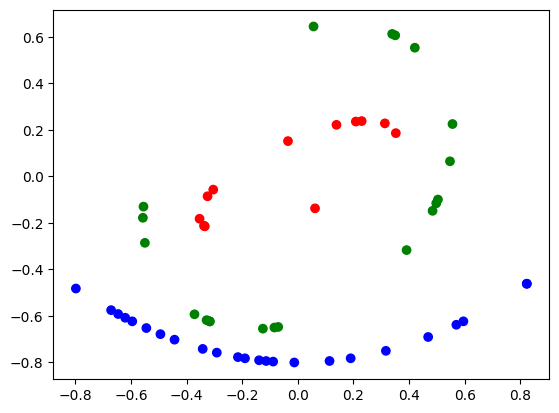

In [55]:
fig, (ax1) = plt.subplots(1)

# График с истинными метками (Y_test)
colors_true = []
for test in Y_test:
    if test == 0:
        colors_true.append('red')
    elif test == 1:
        colors_true.append('green')
    else:
        colors_true.append('blue')
ax1.scatter(X_test[:, 0], X_test[:, 1], color=colors_true)

plt.show()


Построим на классификацию точек во всей области.

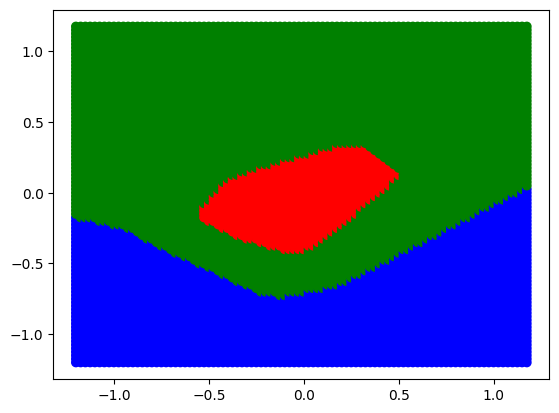

In [56]:
x = np.arange(-1.2, 1.2, 0.025)
combs = np.array(list(product(x, x)))

class test_dataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :]

comb_loader = DataLoader(dataset=test_dataset(combs))

Y_pred = []
for d in comb_loader:
    Y_pred.append(np.argmax(torch.squeeze(model(d), dim=0).tolist()))

colors = []
for val in Y_pred:
    if val == 0:
        colors.append('red')
    elif val == 1:
        colors.append('green')
    else:
        colors.append('blue')

plt.scatter(combs[:,0], combs[:,1], color=colors)


## Задание 2
Использовать сеть с радиальными базисными элементами (RBF) для классификации точек в случае, когда классы не являются линейно разделимыми.


Для создания сети с радиальными базисными элементами (RBF) в PyTorch, можно использовать стандартную архитектуру нейронной сети, состоящую из скрытых слоев, функций активации и выходного слоя для решения задачи регрессии.

In [83]:
class RBF(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RBF, self).__init__()
        self.hidden_dim = hidden_dim #Количество скрытых радиальных базисных функций.
        self.centers = nn.Parameter(torch.randn(hidden_dim, input_dim)) #Параметры центров радиальных функций
        self.beta = nn.Parameter(torch.ones(hidden_dim)) #Параметры бета для каждой радиальной функции, инициализированные единицами в форме (hidden_dim).
        self.weights = nn.Parameter(torch.randn(hidden_dim, output_dim)) #Параметры весовых коэффициентов, инициализированные случайными значениями в форме (hidden_dim, output_dim).

    def radial_basis_function(self, x, center, beta):
        return torch.exp(-beta * torch.norm(x - center, dim=1))#Вычисляет норму (расстояние) между входными данными x и центрами center по размерности 1.

    def forward(self, x):
        rbf_layer = torch.stack([self.radial_basis_function(x, c, b) for c, b in zip(self.centers, self.beta)])#Применяет радиально-базисные функции к входным данным x для каждого центра c и соответствующего параметра beta
        out = torch.matmul(rbf_layer.T, self.weights)#Перемножает полученный тензор радиальных функций с транспонированными весами self.weights для получения выходных данных.
        return out

Определение модели, функции потерь и оптимизатора

In [58]:
input_dim = X_train.shape[1]  # Размерность входных данных
hidden_dim = 10  # Количество скрытых радиальных базисных функций
output_dim = 3  # Количество классов

In [84]:
model = RBF(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [64]:
# Функция обучения
epochs = 300
losses = []
total_correct = 0

for epoch in range(epochs):
    for data, labels in train_loader:
        loss = criterion(model(data), labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

In [65]:
losses[-1]

0.05038854852318764

In [66]:
predicted_labels = []
model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.numpy())

Построим график точек

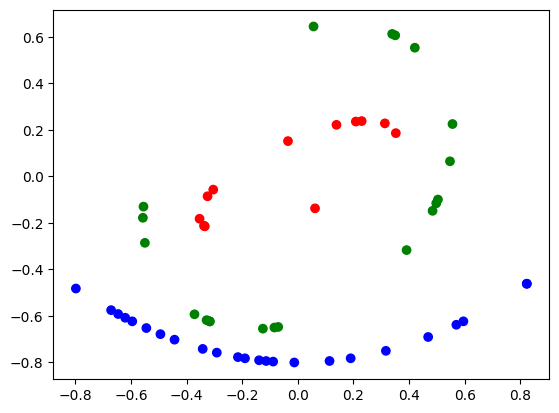

In [67]:
fig, (ax1) = plt.subplots(1)

colors_pred = []
for pred in predicted_labels:
    if pred == 0:
        colors_pred.append('red')
    elif pred == 1:
        colors_pred.append('green')
    else:
        colors_pred.append('blue')

ax1.scatter(X_test[:, 0], X_test[:, 1], color=colors_pred)
plt.show()

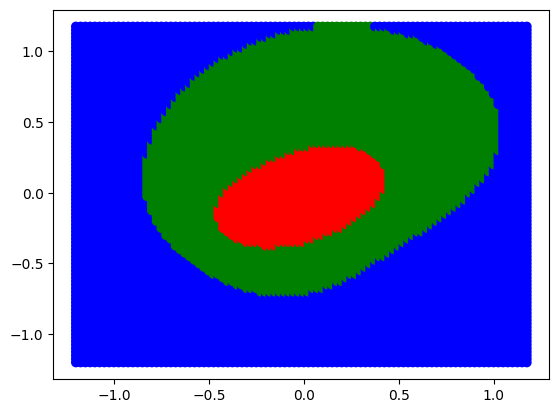

In [68]:
x = np.arange(-1.2, 1.2, 0.025)
combs = np.array(list(product(x, x)))

class test_dataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :]

comb_loader = DataLoader(dataset=test_dataset(combs))

Y_pred = []
for d in comb_loader:
    Y_pred.append(np.argmax(torch.squeeze(model(d), dim=0).tolist()))

colors = []
for val in Y_pred:
    if val == 0:
        colors.append('red')
    elif val == 1:
        colors.append('green')
    else:
        colors.append('blue')

plt.scatter(combs[:,0], combs[:,1], color=colors)


## Задание 3
Использовать обобщенно-регрессионную нейронную сеть для аппроксимации функции.
Проверить работу сети с рыхлыми данными.



Подготавливаем данные из варианта

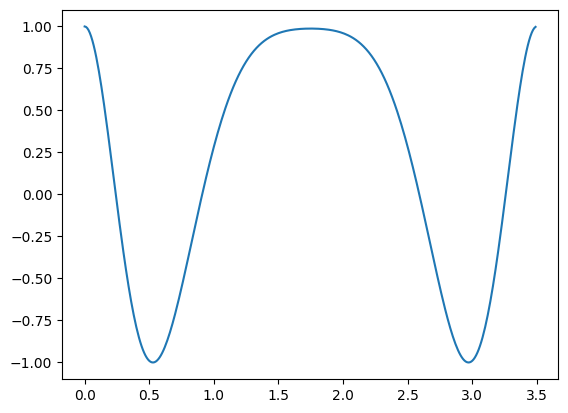

In [3]:
h = 0.01
t = np.arange(0, 3.5, h)
x = np.cos( (-2) * t ** 2 + 7 * t)
plt.plot(t, x)

Разбиваем данные на тренировочную(90%) и тестовую(10%)

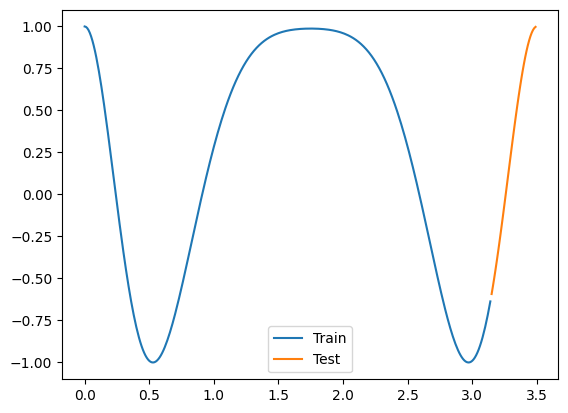

In [11]:
train_size = int(len(t) * 0.9)

X_train = t[:train_size]
y_train = x[:train_size]
plt.plot(X_train, y_train, label='Train')

X_test = t[train_size:]
y_test = x[train_size:]

plt.plot(X_test, y_test, label = 'Test')
plt.legend()
plt.show()

Напишем обобщенно-регрессионную нейронную сеть.

In [74]:
class GRNN(nn.Module):
    def __init__(self, output_dim):
        super(GRNN, self).__init__()
        self.output_dim = output_dim

    def init_weights(self, input_data): # Инициализация весов сети
        self.mu = nn.Parameter(torch.Tensor(input_data.shape[1], self.output_dim).uniform_())# Создает параметр mu, который представляет центры или веса.
        self.sigma = nn.Parameter(torch.Tensor(self.output_dim).uniform_()) # Параметр sigma, который представляет собой параметры ширины для каждого из выходных нейронов в GRNN
        self.sw = nn.Parameter(torch.Tensor(self.output_dim).uniform_()) # Веса для выходных данных

    def forward(self, inputs):
        diff = torch.unsqueeze(inputs, 1) - self.mu
        output = torch.exp(torch.sum(diff**2, dim=2) * self.sigma) # Производит вычисление значений выхода сети, применяя экспоненциальную функцию к сумме квадратов разницы с учетом параметра sigma.
        output = output * self.sw #Выходное значение дополнительно умножается на параметр sw, который может регулировать важность каждого выходного нейрона.
        return output

In [76]:
X_train_tensor = torch.from_numpy(X_train.reshape(-1, 1)).float()
y_train_tensor = y_train.float()


In [77]:
model = GRNN(output_dim=1)
model.init_weights(X_train_tensor)

criterion = nn.MSELoss()
optimizer = torch.optim.LBFGS(model.parameters(), lr=0.01)

In [81]:
epochs = 600
losses = []

def closure():
    optimizer.zero_grad()
    output = model(X_train_tensor)
    loss = criterion(output.squeeze(), y_train_tensor)
    loss.backward()
    losses.append(loss.item())
    return loss

for epoch in range(epochs):
    optimizer.step(closure)

In [82]:
losses[-1]

0.5408327579498291

Выведим график

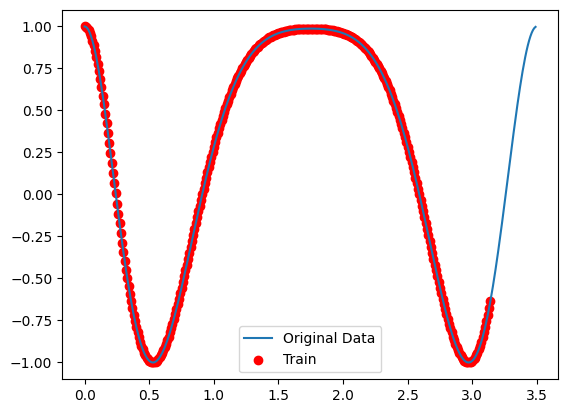

In [37]:
X_test_tensor = torch.from_numpy(X_test.reshape(-1, 1)).float()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze().numpy()

# Plotting
plt.plot(t, x, label='Original Data')
plt.scatter(X_train, y_train, label='Train', color='red')
plt.legend()
plt.show()


Для "рыхлых" данных

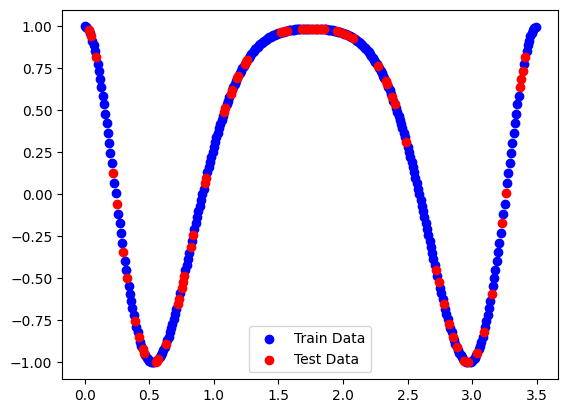

In [17]:
X_train, X_test, y_train, y_test = train_test_split(t, x, test_size=0.2, random_state=42)

# Визуализация результатов разделения
plt.scatter(X_train, y_train, label='Train Data', color='blue')
plt.scatter(X_test, y_test, label='Test Data', color='red')
plt.legend()
plt.show()

## Вывод
В данной работе я познакомилась с нейросетями с радиальными базисными элементами.

Решив, две задачи с помощью RBF и GRNN, можно заметить, что модель обучается быстрее, чем просто использование многослойной неронной сети.

Я считаю, это будет полезно, при оптимизации работы нейронной модели, ведь быстрее получили точность во второй задачи, и меньше RMSE для третьей задачи.

